In [63]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
                            accuracy_score, 
                            precision_score, 
                            recall_score, 
                            f1_score, 
                            roc_curve, 
                            roc_auc_score, 
                            confusion_matrix
                            )
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix

from unbalanced_dataset import OverSampler, SMOTE

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [2]:
CONFIG = {}

with open('config.txt', "r") as in_file:
    for line in in_file:
        line = line.split(":")
        parameter = line[0].strip()
        value = line[1].strip()
        CONFIG[parameter] = value
                
engine_path = 'postgresql://'+CONFIG['username']+':'+\
                CONFIG['password']+'@'+CONFIG['ip']+\
                ':'+CONFIG['port']+'/'+CONFIG['database']
        
engine = create_engine(engine_path)

### Want something like:

    SELECT
        table4.countrycode as 'countrycode',
        b.table1 as 'table1',
        b.table2 as 'table2',
        b.table3 as 'table3',
        table4.year as 'table4'
        (SELECT
            table3.countrycode as 'countrycode',
            a.table1 as 'table1',
            a.table2 as 'table2',
            table3.year as 'table3'
         FROM
            (SELECT
                 table1.countrycode as 'countrycode',
                 table1.year as 'table1',
                 table2.year as 'table2'
             FROM
                 table1
             JOIN
                 table2
               ON 
                 table1.countrycode = table2.countrycode
             ) a
         JOIN
             table3
           ON
             a.countrycode = table3.countrycode  
        ) b    
    JOIN
        table4
      ON
        a.countrycode = table3.countrycode 
    
        
       


In [3]:
def makeSQLQuery(table_names, year):
    dotyyear = '.y' + str(year)
    current_unit = 'a'
    query = '(SELECT ' + table_names[0] + '.countrycode AS countrycode, ' + \
            table_names[0] + dotyyear + ' AS ' + table_names[0] + ', ' + \
            table_names[1] + dotyyear + ' AS ' + table_names[1] + \
            ' FROM ' + table_names[0] + \
            ' JOIN ' + table_names[1] + \
            ' ON ' + table_names[0] + '.countrycode=' + table_names[1] + '.countrycode) '
    query = query + current_unit
    
    for table in table_names[2:]:
        curr_index = table_names.index(table)
        temp_list = table_names[:curr_index+1]
        
        pre_string = '(SELECT ' + table + '.countrycode as countrycode'
        
        for temp_table in temp_list[:-1]:
            pre_string = pre_string + ', ' + current_unit + '.' + temp_table + ' AS ' + temp_table
        
        pre_string = pre_string + ', ' + table + dotyyear + ' AS ' + table
        
        query = pre_string + ' FROM ' + query + ' JOIN ' + table + \
                ' ON ' + current_unit + '.countrycode=' + table + '.countrycode) '
        
        current_unit = current_unit + 'a'
        query = query + current_unit
        
    query = query.rsplit(' ', 1)[0][1:-1]
    
    return query
    
    

In [4]:
table_names = ['corruption_perception', 'life_expectancy', \
               'population_15_64', 'population_65_up', \
                'zscores']

In [5]:
query = makeSQLQuery(table_names, 2013)

In [6]:
data_2013 = pd.read_sql_query(query, engine)

In [7]:
data_2013 = data_2013.set_index('countrycode')

In [8]:
data_2013['zscores'] = data_2013['zscores'].astype(float)

In [9]:
data_2013.head()

,corruption_perception,life_expectancy,population_15_64,population_65_up,zscores
countrycode,,,,,
AFG,8,60.028268,51.920329,2.394414,6.005490
AGO,23,51.866171,49.673340,2.314084,-0.232733
ALB,31,77.537244,68.848024,11.769682,-0.003833
ARE,69,77.195634,85.340053,0.941861,-0.265036
ARG,34,75.986098,63.834426,10.699832,-0.265098


In [10]:

data_2013.loc[data_2013['zscores'] > 0, 'zscores'] = 1
data_2013.loc[data_2013['zscores'] <= 0, 'zscores'] = 0


In [11]:
#The rows to be dropped
data_2013[data_2013.isnull().any(axis=1)]

,corruption_perception,life_expectancy,population_15_64,population_65_up,zscores
countrycode,,,,,
BLZ,NaN,69.982049,62.518994,3.758938,0
FJI,NaN,69.917927,65.713066,5.441534,0
GRD,NaN,73.193561,66.079961,7.154728,0
KIR,NaN,65.766585,61.033314,3.610517,0
MAC,NaN,80.339146,79.257855,8.119094,0
MDV,NaN,76.602610,67.509135,4.775128,0
SLB,NaN,67.718927,56.518544,3.367845,0
TON,NaN,72.640341,56.966492,5.886493,0
VUT,NaN,71.669244,58.783797,4.044398,0


In [12]:
data_2013 = data_2013.dropna()

In [51]:
def getScoreValues(X_train, 
                   X_test, 
                   y_train, 
                   y_test, 
                   model=KNeighborsClassifier(n_neighbors=6), 
                   verbose=True, 
                   verbose_features=True
                  ):
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    
    
    accuracy_score_value = accuracy_score(y_test, y_pred)
    precision_score_value = precision_score(y_test, y_pred)
    recall_score_value = recall_score(y_test, y_pred)
    f1_score_value = f1_score(y_test, y_pred)  
    
    if verbose_features:
        try:
            print(model.feature_importances_)
        except AttributeError:
            pass
    
    if verbose:
        #print(pd.concat([y_test,pd.Series(y_pred, index=y_test.index)], axis = 1))
        print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}'.format(accuracy_score_value, \
                                                                       precision_score_value, \
                                                                       recall_score_value, \
                                                                       f1_score_value))
    
    return accuracy_score_value, precision_score_value, recall_score_value, f1_score_value

In [14]:
X = data_2013[['corruption_perception', 'life_expectancy', \
               'population_15_64', 'population_65_up']]
y = data_2013['zscores']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [15]:
getScoreValues(X_train, X_test, y_train, y_test, DecisionTreeClassifier())

[ 0.38755493  0.27936795  0.20998887  0.12308825]
Accuracy: 0.8823529411764706
Precision: 0.3333333333333333
Recall: 0.5
f1: 0.4


(0.88235294117647056, 0.33333333333333331, 0.5, 0.40000000000000002)

In [16]:
getScoreValues(X_train, X_test, y_train, y_test, BernoulliNB())

Accuracy: 0.9215686274509803
Precision: 0.0
Recall: 0.0
f1: 0.0


/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.92156862745098034, 0.0, 0.0, 0.0)

In [17]:
getScoreValues(X_train, X_test, y_train, y_test, GaussianNB())

Accuracy: 0.8431372549019608
Precision: 0.25
Recall: 0.5
f1: 0.3333333333333333


(0.84313725490196079, 0.25, 0.5, 0.33333333333333331)

In [18]:
getScoreValues(X_train, X_test, y_train, y_test, model=SVC())

Accuracy: 0.9215686274509803
Precision: 0.0
Recall: 0.0
f1: 0.0


/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.92156862745098034, 0.0, 0.0, 0.0)

In [19]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

[ 0.29486078  0.24970469  0.24598146  0.20945306]
Accuracy: 0.9215686274509803
Precision: 0.5
Recall: 0.5
f1: 0.5


(0.92156862745098034, 0.5, 0.5, 0.5)

In [20]:
def getROCcurve(X_train, X_test, y_train, y_test, model=KNeighborsClassifier(n_neighbors=6)):
    model = model
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    auc = roc_auc_score(y_test, y_scores)
    print('AUC: {}'.format(auc))
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(12, 8, forward=True)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend(loc='best')

AUC: 0.8670212765957447


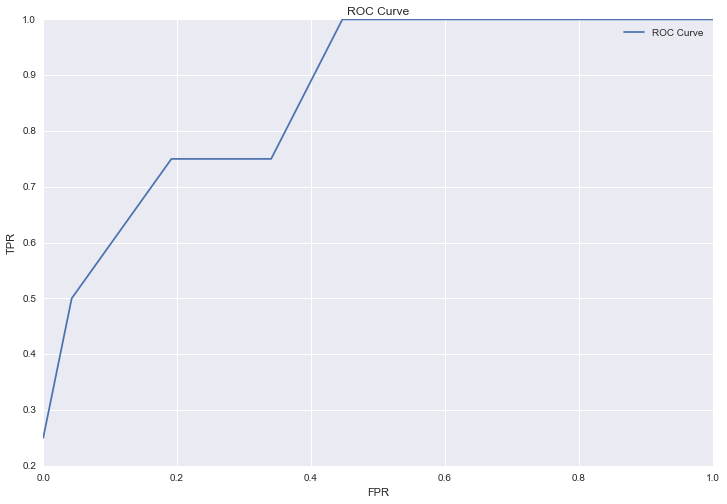

In [21]:
getROCcurve(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

In [22]:
def getScoreValuesByCV(X, y, model=KNeighborsClassifier(n_neighbors=5)):
    
    accuracy_score_value = np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=5))
    precision_score_value = np.mean(cross_val_score(model, X, y, scoring='precision', cv=5))
    recall_score_value = np.mean(cross_val_score(model, X, y, scoring='recall', cv=5))
    f1_score_value = np.mean(cross_val_score(model, X, y, scoring='f1', cv=5))
    roc_auc_value = np.mean(cross_val_score(model, X, y, scoring='roc_auc', cv=5))
    #roc_auc_value = 0  
        
    print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}\nROC AUC: {}'.format(accuracy_score_value, \
                                                                   precision_score_value, \
                                                                   recall_score_value, \
                                                                   f1_score_value,
                                                                   roc_auc_value))

In [23]:
getScoreValuesByCV(X,y)

/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.8521670486376369
Precision: 0.5
Recall: 0.19333333333333336
f1: 0.2666666666666667
ROC AUC: 0.6422495894909688


In [24]:
getScoreValuesByCV(X,y, model=RandomForestClassifier())

/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.8407486631016043
Precision: 0.39999999999999997
Recall: 0.19333333333333333
f1: 0.2442857142857143
ROC AUC: 0.6629146141215106


In [25]:
getScoreValuesByCV(X,y, model=GaussianNB())

Accuracy: 0.7630099312452253
Precision: 0.3437445887445888
Recall: 0.5
f1: 0.40230769230769237
ROC AUC: 0.7106732348111657


In [26]:
getScoreValuesByCV(X,y, model=DecisionTreeClassifier())

Accuracy: 0.7985128596893303
Precision: 0.305
Recall: 0.34
f1: 0.3135353535353535
ROC AUC: 0.600623973727422


In [27]:
getScoreValuesByCV(X,y, model=LogisticRegression())

/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/met

Accuracy: 0.8462846956964605
Precision: 0.0
Recall: 0.0
f1: 0.0
ROC AUC: 0.6753694581280788


/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Over sampling

In [28]:
x_cols = ['corruption_perception', 'life_expectancy', \
               'population_15_64', 'population_65_up']

In [29]:
X = data_2013[x_cols]
y = data_2013['zscores']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [30]:
verbose = False
ratio = float(y.value_counts()[0]) / float(y.value_counts()[1])
X_train = X_train.reset_index(drop=True).as_matrix()
y_train = y_train.reset_index(drop=True).as_matrix()

smote = SMOTE(ratio=ratio, verbose=verbose)
smox, smoy = smote.fit_transform(X_train, y_train)

In [31]:
#smox

In [32]:
X_train = pd.DataFrame(smox, columns=x_cols)
y_train = pd.Series(smoy)

In [33]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

[ 0.26950716  0.30894954  0.25318631  0.16835699]
Accuracy: 0.8431372549019608
Precision: 0.3
Recall: 0.75
f1: 0.4285714285714285


(0.84313725490196079, 0.29999999999999999, 0.75, 0.42857142857142849)

In [34]:
getScoreValues(X_train, X_test, y_train, y_test, model=BernoulliNB())

Accuracy: 0.0784313725490196
Precision: 0.0784313725490196
Recall: 1.0
f1: 0.14545454545454545


(0.078431372549019607, 0.078431372549019607, 1.0, 0.14545454545454545)

In [35]:
getScoreValues(X_train, X_test, y_train, y_test, model=GaussianNB())

Accuracy: 0.5686274509803921
Precision: 0.09090909090909091
Recall: 0.5
f1: 0.15384615384615385


(0.56862745098039214, 0.090909090909090912, 0.5, 0.15384615384615385)

In [36]:
getScoreValues(X_train, X_test, y_train, y_test, model=DecisionTreeClassifier())

[ 0.24358454  0.30332652  0.27403072  0.17905822]
Accuracy: 0.803921568627451
Precision: 0.25
Recall: 0.75
f1: 0.375


(0.80392156862745101, 0.25, 0.75, 0.375)

In [37]:
getScoreValues(X_train, X_test, y_train, y_test)

Accuracy: 0.6666666666666666
Precision: 0.15789473684210525
Recall: 0.75
f1: 0.2608695652173913


(0.66666666666666663, 0.15789473684210525, 0.75, 0.2608695652173913)

## Confusion Matrix

In [38]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Not at Risk', 'At Risk'], rotation=45)
    plt.yticks(tick_marks, ['Not at Risk', 'At Risk'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Cross validate with oversampling

In [83]:
def getCrossValScoresBySSS(local_X, 
                           local_y, 
                           n_iter=30, 
                           test_size=0.3, 
                           model=KNeighborsClassifier(n_neighbors=6),
                           get_multi_models=False,
                           get_models_avg=False,
                           get_cm=False,
                           verbose=True,
                           verbose_features=True
                          ):
    
    score_dict = {}
    acc_array = []
    prec_array = []
    recall_array = []
    f1_array = []
    sss = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size)
    
    model_list = [\
                  KNeighborsClassifier(n_neighbors=6), \
                  LogisticRegression(), \
                  GaussianNB(), \
                  RandomForestClassifier(), \
                  DecisionTreeClassifier() \
                  ]
    
    #Return table of scores for each model
    if get_multi_models:
        model_acc = []
        model_prec = []
        model_rec = []
        model_f1 = []
        for a_model in model_list:
            acc_array = []
            prec_array = []
            recall_array = []
            f1_array = []
            for train_index, test_index in sss:
                #print("TRAIN:", train_index, "TEST:", test_index)
                X_train, X_test = X.ix[train_index], X.ix[test_index]
                y_train, y_test = y.ix[train_index], y.ix[test_index]

                X_train = X_train.reset_index(drop=True).as_matrix()
                y_train = y_train.reset_index(drop=True).as_matrix()

                smote = SMOTE(ratio=ratio, verbose=False)
                smox, smoy = smote.fit_transform(X_train, y_train)
                X_train = pd.DataFrame(smox, columns=x_cols)
                y_train = pd.Series(smoy)
            
                accuracy_score_value, precision_score_value, \
                recall_score_value, f1_score_value = getScoreValues(X_train, 
                                                                   X_test, 
                                                                   y_train, 
                                                                   y_test, 
                                                                   model=a_model, 
                                                                   verbose=False,
                                                                   verbose_features=False)
                
                acc_array.append(accuracy_score_value)
                prec_array.append(precision_score_value)
                recall_array.append(recall_score_value)
                f1_array.append(f1_score_value)
                
            mean_acc = np.mean(acc_array)
            mean_prec = np.mean(prec_array)
            mean_recall = np.mean(recall_array)
            mean_f1 = np.mean(f1_array)
            
            model_acc.append(mean_acc)
            model_prec.append(mean_prec)
            model_rec.append(mean_recall)
            model_f1.append(mean_f1)
            
        score_dict['Accuracy'] = model_acc
        score_dict['Precision'] = model_prec
        score_dict['Recall'] = model_rec
        score_dict['F1'] = model_f1
        
        col_names = ['Accuracy', 'Precision', 'Recall', 'F1']
        index_func = [\
                  'KNeighborsClassifier(n_neighbors=6)', \
                  'LogisticRegression()', \
                  'GaussianNB()', \
                  'RandomForestClassifier()', \
                  'DecisionTreeClassifier()' \
                  ]
        df = pd.DataFrame(score_dict, columns=col_names, index=index_func)
        return df
    
    
    else:
        for train_index, test_index in sss:
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X.ix[train_index], X.ix[test_index]
            y_train, y_test = y.ix[train_index], y.ix[test_index]

            X_train = X_train.reset_index(drop=True).as_matrix()
            y_train = y_train.reset_index(drop=True).as_matrix()

            smote = SMOTE(ratio=ratio, verbose=False)
            smox, smoy = smote.fit_transform(X_train, y_train)
            X_train = pd.DataFrame(smox, columns=x_cols)
            y_train = pd.Series(smoy)

            #Get scores of the average prediction of multiple models
            if get_models_avg:
                y_predictions = []

                for a_model in model_list:
                    temp_model = a_model
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    y_predictions.append(y_pred)

                average_prediction = np.mean(y_predictions, axis=0)
                average_prediction = [int(round(n, 0)) for n in average_prediction]

                accuracy_score_value = accuracy_score(y_test, y_pred)
                precision_score_value = precision_score(y_test, y_pred)
                recall_score_value = recall_score(y_test, y_pred)
                f1_score_value = f1_score(y_test, y_pred)

                acc_array.append(accuracy_score_value)
                prec_array.append(precision_score_value)
                recall_array.append(recall_score_value)
                f1_array.append(f1_score_value)

            #Get score values for each fold
            else:
                accuracy_score_value, precision_score_value, \
                recall_score_value, f1_score_value = getScoreValues(X_train, 
                                                                   X_test, 
                                                                   y_train, 
                                                                   y_test, 
                                                                   model=model, 
                                                                   verbose=False,
                                                                   verbose_features=verbose_features)

                if get_cm:
                    # For getting a confusion matrix of the last model in the cross validated set
                    temp_model = model
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)

                acc_array.append(accuracy_score_value)
                prec_array.append(precision_score_value)
                recall_array.append(recall_score_value)
                f1_array.append(f1_score_value)

        if get_cm:
            cm = confusion_matrix(y_test, average_prediction)
            plt.figure()
            plot_confusion_matrix(cm)

        mean_acc = np.mean(acc_array)
        mean_prec = np.mean(prec_array)
        mean_recall = np.mean(recall_array)
        mean_f1 = np.mean(f1_array)

        if verbose:
            print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}'.format(mean_acc, \
                                                                           mean_prec, \
                                                                           mean_recall,\
                                                                           mean_f1))

In [84]:
X = data_2013[x_cols]
y = data_2013['zscores']

## Scores for various models

In [85]:
getCrossValScoresBySSS(X, y, get_multi_models=True)

,Accuracy,Precision,Recall,F1
KNeighborsClassifier(n_neighbors=6),0.694118,0.259582,0.512500,0.340661
LogisticRegression(),0.522876,0.202880,0.695833,0.312701
GaussianNB(),0.584314,0.223697,0.654167,0.331356
RandomForestClassifier(),0.730065,0.262718,0.341667,0.288135
DecisionTreeClassifier(),0.695425,0.207128,0.333333,0.249232


#### KNN various n


In [54]:
for n in range(1,8):
    print('n = ', n)
    getCrossValScoresBySSS(X, y, model=KNeighborsClassifier(n_neighbors=n))
    print('\n')

n =  1
Accuracy: 0.7091503267973859
Precision: 0.2632127567421685
Recall: 0.45416666666666666
f1: 0.3262321287329758


n =  2
Accuracy: 0.7405228758169937
Precision: 0.2722529213705684
Recall: 0.3875
f1: 0.310882603773437


n =  3
Accuracy: 0.6673202614379087
Precision: 0.2503057136088163
Recall: 0.5583333333333333
f1: 0.3412364437864052


n =  4
Accuracy: 0.7111111111111114
Precision: 0.2800566073360191
Recall: 0.5041666666666667
f1: 0.35544341910912114


n =  5
Accuracy: 0.6464052287581701
Precision: 0.23483258955914463
Recall: 0.5458333333333333
f1: 0.3252824464574761


n =  6
Accuracy: 0.6686274509803923
Precision: 0.2513869395885818
Recall: 0.5458333333333333
f1: 0.3401668203889633


n =  7
Accuracy: 0.6130718954248366
Precision: 0.23664804289745112
Recall: 0.65
f1: 0.3439279711113739




#### Random Forest for important features

In [58]:
getCrossValScoresBySSS(X, y, model=RandomForestClassifier())

[ 0.27325142  0.30722942  0.22105895  0.19846021]
[ 0.2667839   0.32522402  0.23729427  0.17069781]
[ 0.30695013  0.30362419  0.187903    0.20152267]
[ 0.28500325  0.29050622  0.27457821  0.14991232]
[ 0.25814981  0.28229142  0.23110184  0.22845693]
[ 0.26598692  0.24944414  0.28538248  0.19918646]
[ 0.18650252  0.31004266  0.32008154  0.18337328]
[ 0.24028809  0.26244146  0.32008137  0.17718908]
[ 0.28500034  0.26094256  0.21790822  0.23614888]
[ 0.33737164  0.25821427  0.2263388   0.17807529]
[ 0.2278693   0.30972795  0.26707751  0.19532524]
[ 0.17211776  0.36456952  0.34070709  0.12260563]
[ 0.2238417   0.30652663  0.27909139  0.19054028]
[ 0.20899464  0.26596289  0.32563021  0.19941226]
[ 0.41798851  0.30480357  0.15482127  0.12238666]
[ 0.40912829  0.19529507  0.24305117  0.15252546]
[ 0.27649904  0.31748886  0.24030144  0.16571065]
[ 0.30551486  0.26178591  0.25041727  0.18228196]
[ 0.16197218  0.39015557  0.25108472  0.19678753]
[ 0.28900688  0.28921996  0.27940347  0.14236969]


#### DecisionTreeClassifier for important features

In [59]:
getCrossValScoresBySSS(X, y, model=DecisionTreeClassifier())

[ 0.42998285  0.2616411   0.20719664  0.10117941]
[ 0.18838982  0.4072595   0.21417861  0.19017208]
[ 0.35344274  0.32009331  0.16895875  0.1575052 ]
[ 0.31729961  0.20386775  0.34754882  0.13128383]
[ 0.23631758  0.4069836   0.07044495  0.28625386]
[ 0.29695559  0.22082384  0.35279967  0.1294209 ]
[ 0.14911318  0.53296484  0.20166596  0.11625602]
[ 0.34803671  0.20627884  0.18975964  0.25592481]
[ 0.2968597   0.25890368  0.30250473  0.1417319 ]
[ 0.41618374  0.28962589  0.21199452  0.08219585]
[ 0.12330542  0.26408948  0.44758404  0.16502106]
[ 0.30514466  0.18326694  0.23671687  0.27487153]
[ 0.14749983  0.18407883  0.55114034  0.117281  ]
[ 0.14974078  0.30046501  0.29722123  0.25257298]
[ 0.33597282  0.13149861  0.43757763  0.09495094]
[ 0.29610543  0.2692761   0.19924965  0.23536881]
[ 0.16989303  0.53705642  0.09754083  0.19550973]
[ 0.16882557  0.4467511   0.22540016  0.15902317]
[ 0.25157229  0.34625635  0.1978297   0.20434166]
[ 0.31829421  0.19282242  0.21054654  0.27833684]


### Model averages:

In [60]:
getCrossValScoresBySSS(X, y, get_models_avg=True)

Accuracy: 0.6973856209150328
Precision: 0.2786619640984293
Recall: 0.6
f1: 0.3781948370257372
